<a href="https://www.kaggle.com/code/sccsmartcode/image-captioning?scriptVersionId=208401176" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import zipfile
import re
import gc
import nltk
nltk.data.path.append('/usr/local/share/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/share/nltk_data')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch.nn.utils.rnn import pad_sequence
from torchvision.io import read_image
import torchvision.transforms as tt
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision.models import inception_v3
from collections import Counter
# from torchsummary import summary
from torch.optim import Adam
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import random
%pip install wandb
# %wandb login
import wandb
import matplotlib.pyplot as plt

torch.manual_seed(50)

[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv("/kaggle/input/flickr-8k-csv-dataset/captions.csv", delimiter=',')

texts = " ".join(df['caption'].tolist())
cleaned_texts = re.sub(r'[^a-zA-Z\s]', ' ', texts).lower()
words = word_tokenize(cleaned_texts)

with zipfile.ZipFile('/usr/local/share/nltk_data/corpora/wordnet.zip', 'r') as zip_ref:
    zip_ref.extractall('/usr/local/share/nltk_data/corpora/')
counter = Counter(words)

vocab = [word for word, count in counter.items() if count >= 5]


BOS_TOKEN = "<BOS>"
EOS_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

vocab.insert(0, BOS_TOKEN)
vocab.insert(1, PAD_TOKEN)
vocab.insert(2, EOS_TOKEN)
vocab.insert(3, UNK_TOKEN)

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

print("Vocabulary Size:", len(vocab))
print("Sample Vocabulary:", vocab[:120])

Vocabulary Size: 2975
Sample Vocabulary: ['<BOS>', '<PAD>', '<EOS>', '<UNK>', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'playhouse', 'the', 'to', 'her', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tri', 'colored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'breeds', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'canvas', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'starring', 'something', 'wears', 'glasses', 'wearing', 'beer', 'can', 'pierced', 'ears', 'rope', 'net'

In [3]:
class ICDataset(Dataset):
    img_base_folder = "/kaggle/input/flickr8k/Images"

    def __init__(self, transforms=None):
        super(ICDataset, self).__init__()
        self.dataset_metadata = []
        idx = 0
        while idx < len(df['image']):
            self.dataset_metadata.append([df['image'][idx], df['caption'][idx]])
            idx += 5
        self.transforms = transforms
        self.max_caption_length = 50

    def __getitem__(self, idx):
        file_name, caption = self.dataset_metadata[idx]
        image = read_image(os.path.join(self.img_base_folder, file_name))/255
        if self.transforms:
            image = self.transforms(image)
        target = self.parse_caption(caption)
        return image, target

    def parse_caption(self, caption=""):
        cleaned_texts = re.sub(r'[^a-zA-Z\s]', ' ', caption).lower()
        words = word_tokenize(cleaned_texts)
        input_indices = [word_to_idx[word] if word in word_to_idx else word_to_idx[UNK_TOKEN]  for word in words]
        input_vector = torch.tensor(input_indices)


        if len(input_vector) > self.max_caption_length-2:
            input_vector = input_vector[:self.max_caption_length-2]
            input_vector = torch.cat((torch.tensor([word_to_idx[BOS_TOKEN]]), input_vector, torch.tensor([word_to_idx[EOS_TOKEN]])))
        else:
            input_vector = torch.cat((torch.tensor([word_to_idx[BOS_TOKEN]]), input_vector, torch.tensor([word_to_idx[EOS_TOKEN]])))
            input_vector = torch.cat((input_vector, torch.tensor([word_to_idx[PAD_TOKEN] for _ in range(self.max_caption_length - len(input_vector))])))



        return input_vector.to(dtype=torch.long)

    def __len__(self):
        return len(self.dataset_metadata)

In [4]:
hyperparameters = {
    "batch_size": 3,
    "embedding_dim": 512,
    "num_embeddings": len(idx_to_word),
    "epochs": 4,
    "hidden_size": 1024
}

In [5]:
transform = tt.Compose([
    tt.Resize((224, 224)),
])

In [6]:
dataset = ICDataset(transforms=transform)
train_ds, valid_ds, test_ds = random_split(dataset, [7200, 91, 800])

train_dl = DataLoader(train_ds, batch_size=hyperparameters['batch_size'], shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=int(hyperparameters['batch_size']), drop_last=True, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=int(hyperparameters['batch_size']), drop_last=True)

In [7]:
class CustomDL:
    def __init__(self, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for inputs, targets in self.dataloader:
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)

            yield inputs, targets

            del inputs, targets
            torch.cuda.empty_cache() if self.device == 'cuda' else None
            gc.collect()

    def __len__(self):
        return len(self.dataloader)

custom_train_dl = CustomDL(train_dl)
custom_valid_dl = CustomDL(valid_dl)
custom_test_dl = CustomDL(test_dl)

In [52]:
from torchvision.models import resnet50, ResNet50_Weights

class CNN_Encoder(nn.Module):
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hyperparameters['embedding_dim'])

        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        features = self.resnet(images)
        return features



class RNN_Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=3):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, features, captions, hidden=None, cell_state=None):
        embeddings = self.embedding(captions)
        features = features.unsqueeze(1)
        embeddings = embeddings.unsqueeze(1) if len(embeddings.shape) != len(features.shape) else embeddings

        lstm_input = torch.cat((features, embeddings), dim=1)

        

        if hidden == None:
            output, (hidden, cell_state) = self.lstm(lstm_input)
        else:
            output, (hidden, cell_state) = self.lstm(lstm_input, (hidden, cell_state))


        outputs = self.fc(output[:,-1:])

        return outputs, (hidden, cell_state)

    def init_hidden(self, batch_size):
        h_t = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_t = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h_t, c_t


encoder = CNN_Encoder()
decoder = RNN_Decoder(embed_size=hyperparameters['embedding_dim'], hidden_size=hyperparameters['hidden_size'], vocab_size=hyperparameters['num_embeddings'], num_layers=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = encoder.to(device)
decoder = decoder.to(device)

In [9]:
optimizers = {
    'encoder': Adam(encoder.parameters()),
    'decoder': Adam(decoder.parameters())
        }
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<PAD>'])

In [10]:
wandb.init(
    project="Image Captioning",

    config={
    "architecture": "Encoder-Decoder",
    "dataset": "flickr30k_images",
    "epochs": 10,
    }
)

wandb.watch([encoder, decoder], criterion, log="all")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[]

In [10]:
def inference(dl):
    encoder.eval()
    decoder.eval()

    for batch in dl:
        inputs, targets = batch
        with torch.no_grad():
            features = encoder(inputs)
            
            batch_size, time_step = targets.shape[0], targets.shape[1]
            h_t, c_t = None, None

            outputs_seq = torch.zeros(batch_size, time_step).to(device)
            i_t = torch.tensor([[word_to_idx['<BOS>']] for x in range(batch_size)]).to(device)

            for t in range(time_step-1):
                
                new_i_t, (h_t, c_t) = decoder(features, i_t, h_t, c_t)                    
                i_t = new_i_t.argmax(dim=2).squeeze()
                outputs_seq[:, t] = i_t

            for i in range(len(outputs_seq)):
                pred_caption = [idx_to_word[idx.item()] for idx in outputs_seq[i]]
                target_caption = [idx_to_word[idx.item()] for idx in targets[i]]

                image = inputs[i].permute(1, 2, 0).cpu().numpy()
                image = (image - image.min()) / (image.max() - image.min())

                plt.imshow(image)
                plt.title(f"Predicted: {' '.join([val for val in pred_caption if val not in ['<BOS>', '<EOS>', '<UNK>', '<PAD>']])}\nTarget: {' '.join([val for val in target_caption if val not in ['<BOS>', '<EOS>', '<UNK>', '<PAD>']])}")
                plt.axis('off')
                plt.show()

                return


In [12]:
def fit(num_epochs, encoder, decoder, optimizers, criterion, train_dl, valid_dl, teacher_forcing_ratio=0.5):

    for epoch in range(num_epochs):
       
        total_loss = 0
        running_loss = 0
        loss = float('inf')

        for batch_idx, batch in enumerate(tqdm(train_dl, desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch')):
            decoder.train()
            inputs, targets = batch

            opt_encoder = optimizers['encoder']
            opt_decoder = optimizers['decoder']

            opt_decoder.zero_grad()

            features = encoder(inputs)

            batch_size, time_step = targets.shape[0], targets.shape[1]
            h_t, c_t = None, None

            outputs_seq = torch.zeros(batch_size, time_step, hyperparameters['num_embeddings']).to(device)
            i_t = torch.tensor([[word_to_idx['<BOS>']] for x in range(batch_size)]).to(device)

            for t in range(time_step):
                i_t, (h_t, c_t) = decoder(features, i_t, h_t, c_t)
                outputs_seq[:, t, :] = i_t.squeeze()

                use_teacher_forcing = random.random() < teacher_forcing_ratio
                if use_teacher_forcing:
                    i_t = targets[:, t]
                else:
                    i_t = i_t.argmax(dim=1)

            loss = criterion(outputs_seq.view(-1, hyperparameters['num_embeddings']), targets.view(-1))
            loss.backward()
            opt_decoder.step()
            torch.save(decoder.state_dict(), "parameter.pth")

            total_loss += loss.item()
            running_loss += loss.item()

            if (batch_idx + 1) % 200 == 0:
                
                inference(valid_dl)

            if (batch_idx + 1) % 500 == 0:
                
                avg_loss_so_far = running_loss / 500
                wandb.log({
                    "in-batch-loss": avg_loss_so_far,
                })
                print(f"Batch {batch_idx + 1}, Avg In-Batch Loss: {avg_loss_so_far:.4f}")

                running_loss = 0
                decoder.eval()
                with torch.no_grad():
                    val_loss = 0
                    references = []
                    candidates = []
        
                    for batch in valid_dl:
                        inputs, targets = batch
        
                        features = encoder(inputs)
        
                        batch_size, time_step = targets.shape[0], targets.shape[1]
        
                        h_t, c_t = None, None
                        outputs_seq = torch.zeros(batch_size, time_step, hyperparameters['num_embeddings']).to(device)
                        i_t = torch.tensor([[word_to_idx['<BOS>']] for x in range(batch_size)]).to(device)
        
                        for t in range(time_step):
                            i_t, (h_t, c_t) = decoder(features, i_t, h_t, c_t)
                            outputs_seq[:, t, :] = i_t.squeeze()
                            i_t = i_t.argmax(dim=1)
        
                        val_loss += criterion(outputs_seq.view(-1, hyperparameters['num_embeddings']), targets.view(-1)).item()
        
                        candidates.append(outputs_seq.argmax(dim=-1).tolist())
                        references.append(targets.tolist())
        
                    candidates = [item for sublist in candidates for item in sublist]
                    references = [item for sublist in references for item in sublist]
        
                    candidates_words = [[idx_to_word[idx] for idx in candidate] for candidate in candidates]
                    references_words = [[[idx_to_word[idx] for idx in reference]] for reference in references]
        
                    bleu_score = corpus_bleu(references_words, candidates_words, smoothing_function=SmoothingFunction().method1)
        
                    print(f"Validation Loss: {val_loss / len(valid_dl):.4f}, BLEU Score: {bleu_score:.4f}")
                    wandb.log({
                        "epoch-valid-loss": val_loss / len(valid_dl),
                        "epoch-bleu-score": bleu_score
                    })

In [13]:
# fit(2, encoder, decoder, optimizers, criterion, custom_train_dl, custom_valid_dl, teacher_forcing_ratio=0.8)

In [ ]:
# torch.save(decoder.state_dict(), "kaggle_new_new_cap_parameter.pth")

In [ ]:
# wandb.finish()

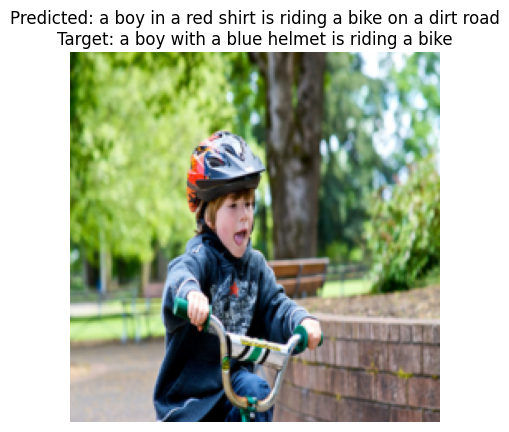

In [22]:
inference(custom_valid_dl)

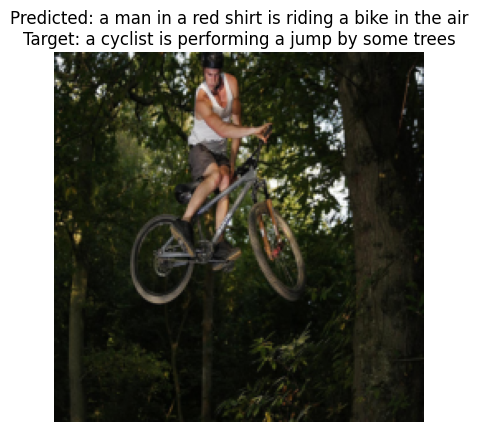

In [17]:
inference(custom_valid_dl)

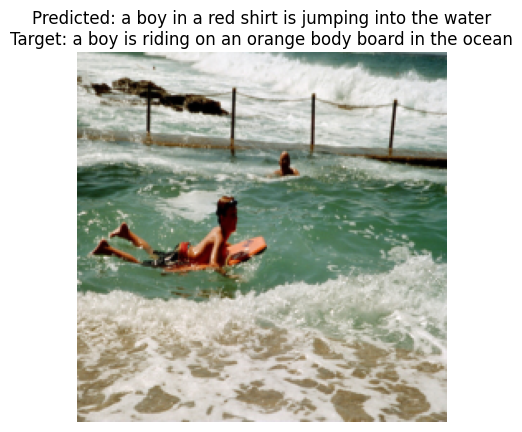

In [24]:
inference(custom_valid_dl)

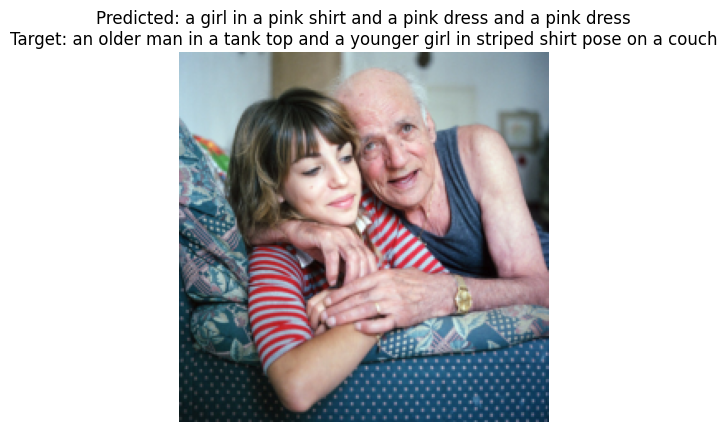

In [30]:
inference(custom_valid_dl)

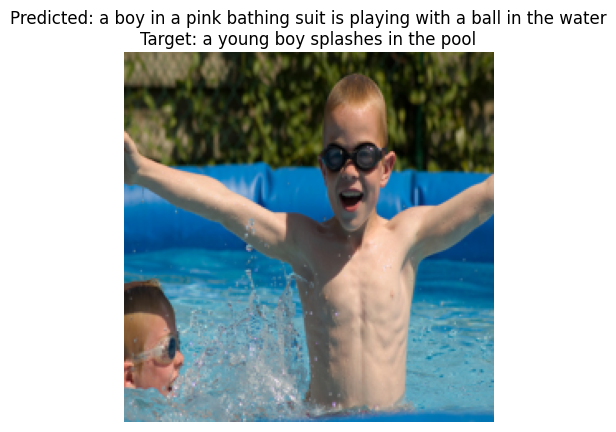

In [51]:
inference(custom_valid_dl)

In [18]:
# torch.save(decoder.state_dict(), 'kaggle_new_new_cap_parameter8.pth')
# artifact = wandb.Artifact('model-parameters-1', type='model')
# artifact.add_file('kaggle_new_new_cap_parameter8.pth')
# wandb.log_artifact(artifact)

<Artifact model-parameters-1>